In [1]:
import sys
sys.path.append('/home/huyvu/workspace/thesis/SEAL-Python/')

In [2]:
from seal import * 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [7]:
from ckks_scheme import setup_ckks_params, create_tools

poly_modulus_degree = 2**14
coeff_modulus_chain = [60, 50, 50, 50, 50, 50, 50, 60]
scale = 2.0 ** 50
context = setup_ckks_params(poly_modulus_degree, coeff_modulus_chain)
secret_key, public_key, relin_keys, galois_keys, encryptor, decryptor, evaluator, ckks_encoder = create_tools(context)
slot_count = ckks_encoder.slot_count()

/
| Encryption parameters
| scheme: ckks
| poly_modulus_degree: 16384
| coeff_modulus size: 420(60 + 50 + 50 + 50 + 50 + 50 + 50 + 60) bits
\


### Dot product of two vectors containing ciphertexts

In [8]:
from functions import eval_poly_approximate_sigmoid_ckks
from functions import dot_product_two_ciphertext
from remez import eval_poly_approximate_sigmoid

A = [ 1, 0, -1, 3]

A_ptx = [ckks_encoder.encode([a], scale) for a in A]
A_ctx = [encryptor.encrypt(a_ptx) for a_ptx in A_ptx]

B = [ 1, 0, -1, 1]
B_ptx = [ckks_encoder.encode([b], scale) for b in B]
B_ctx = [encryptor.encrypt(b_ptx) for b_ptx in B_ptx]
input_number = np.dot(A,B)
mult = dot_product_two_ciphertext(A_ctx, B_ctx, evaluator, relin_keys)

sigmoidCKKS_ctx = eval_poly_approximate_sigmoid_ckks(mult, ckks_encoder, scale, evaluator, relin_keys)
sigmoidCKKS_ptx = decryptor.decrypt(sigmoidCKKS_ctx)
sigmoidCKKS = ckks_encoder.decode(sigmoidCKKS_ptx)

expectedValues = eval_poly_approximate_sigmoid(input_number)

print("Input values:", input_number)
print("Expected approximate result:", np.round(expectedValues, 3))
print("Actual approximate result:", np.round(sigmoidCKKS[0], 3))

Input values: 5
Expected approximate result: 0.985
Actual approximate result: 0.985


In [10]:
from functions import sum_slots, print_vector

slot_count = ckks_encoder.slot_count()
input_vector = [1] * 1500
input_ptx = ckks_encoder.encode(input_vector , scale)
input_ctx = encryptor.encrypt(input_ptx)

sumslots_ctx = sum_slots(input_ctx, evaluator, galois_keys, slot_count)

sumslots_ptx = decryptor.decrypt(sumslots_ctx)
sumslots = ckks_encoder.decode(sumslots_ptx)
print("Input vector:", end = ' ')
print_vector(input_vector)
print("Sum of 64 slots:", np.round(sumslots[0],3))


Input vector: [1.000, 1.000, 1.000, 1.000, 1.000, ...]
Sum of 64 slots: 1500.0


In [11]:
from functions import eval_poly_approximate_sigmoid_ckks
from remez import eval_poly_approximate_sigmoid

input_number = [5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5]

input_ptx = ckks_encoder.encode(input_number, scale)
input_ctx = encryptor.encrypt(input_ptx)
sigmoidCKKS_ctx = eval_poly_approximate_sigmoid_ckks(input_ctx, ckks_encoder, scale, evaluator, relin_keys)

sigmoidCKKS_ptx = decryptor.decrypt(sigmoidCKKS_ctx)
sigmoidCKKS = ckks_encoder.decode(sigmoidCKKS_ptx)

expectedValues = [eval_poly_approximate_sigmoid(i) for i in input_number]

def round_vector(vector_x):
    rounded_vector = [np.round(x, 3) for x in vector_x]
    return rounded_vector

print("Input values: ", input_number)
print("Expected approximate result:", round_vector(expectedValues))
print("Actual approximate result:", round_vector(sigmoidCKKS[:len(input_number)]))


Input values:  [5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5]
Expected approximate result: [0.985, 1.032, 0.983, 0.862, 0.693, 0.5, 0.307, 0.138, 0.017, -0.032, 0.015]
Actual approximate result: [0.985, 1.032, 0.983, 0.862, 0.693, 0.5, 0.307, 0.138, 0.017, -0.032, 0.015]


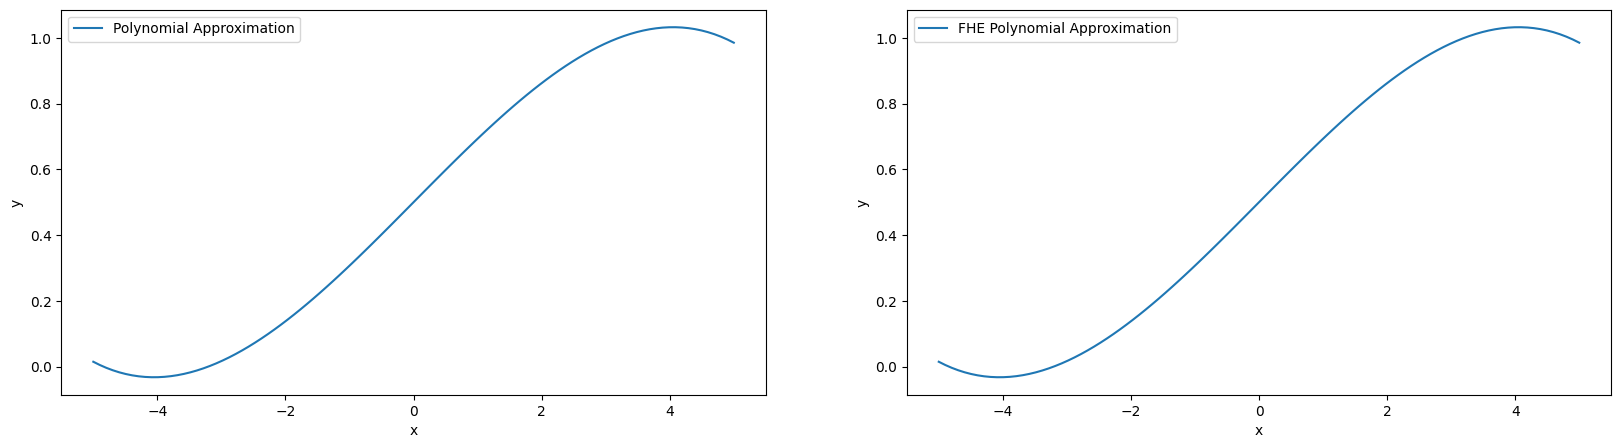

In [12]:
import matplotlib.pyplot as plt

interval = [-5, 5]
x = np.linspace(interval[0], interval[1], 100)
y_poly = np.array([eval_poly_approximate_sigmoid(x_i) for x_i in x])

x_ptx = [ckks_encoder.encode(x_i, scale) for x_i in x]
x_ctx = [encryptor.encrypt(x_i_ptx) for x_i_ptx in x_ptx]
y_ctx = [eval_poly_approximate_sigmoid_ckks(x_i_ctx, ckks_encoder, scale, evaluator, relin_keys) for x_i_ctx in x_ctx]
y_ptx = [decryptor.decrypt(y_i_ctx) for y_i_ctx in y_ctx]
y_fhe = [ckks_encoder.decode(y_i_ptx)[0] for y_i_ptx in y_ptx]

_, axs = plt.subplots(1, 2, figsize = (20,5))
axs[0].plot(x, y_poly, label=f"Polynomial Approximation")  
axs[0].legend()
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

axs[1].plot(x, y_fhe, label=f"FHE Polynomial Approximation")
axs[1].legend()
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.show()